# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [5]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [6]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [7]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [13]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

### Запуск базовой модели с семинара на новом датасете


In [24]:
import torch
import torch.nn as nn

class Aggregator(nn.Module):
    def forward(self, outputs):
        raise NotImplementedError("Aggregator must implement the forward method")

class MaxAggregator(Aggregator):
    def forward(self, outputs):
        return outputs.max(dim=1)[0]

class MeanAggregator(Aggregator):
    def forward(self, outputs):
        return outputs.mean(dim=1)

In [30]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, dropout_value: float,
        num_classes: int = 4,
        aggregator: Aggregator = MaxAggregator()
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_value)

        self.aggregator = aggregator

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        output = self.aggregator(output)

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction


def choose_aggregator(aggregation_type: str) -> Aggregator:
  if aggregation_type == 'max':
      return MaxAggregator()
  elif aggregation_type == 'mean':
      return MeanAggregator()
  else:
      raise ValueError(f"Unsupported aggregation type: {aggregation_type}")

In [31]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """
    predictions = []
    targets = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            targets.append(batch['label'])

    predictions = torch.cat(predictions)
    targets = torch.cat(targets)
    accuracy = (predictions == targets).float().mean().item()

    return accuracy

In [32]:
def train(model, train_dataloader, criterion, optimizer, device, num_epochs, eval_steps, eval_dataloader):
    losses = []
    acc = []

    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            input_ids, labels = batch['input_ids'].to(device), batch['label'].to(device)
            logits = model(input_ids)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0 and i != 0:
                accuracy = evaluate(model, eval_dataloader)
                acc.append(accuracy)
                model.train()  # Ensure model is back in training mode

        epoch_loss = sum(epoch_losses) / len(epoch_losses)
        losses.append(epoch_loss)

    return losses, acc

def run_training_sessions(model, train_dataloader, eval_dataloader, device, num_epochs, eval_steps):
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    aggregation_types = ['max', 'mean']
    results = {}

    for aggregation_type in aggregation_types:
        print(f"Starting training for {aggregation_type}")
        model.aggregator = choose_aggregator(aggregation_type)
        model.to(device)

        losses, acc = train(model, train_dataloader, criterion, optimizer, device, num_epochs, eval_steps, eval_dataloader)

        results[aggregation_type] = {
            'losses': losses,
            'accuracy': acc
        }

    return results

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CharLM(hidden_dim=256, vocab_size=len(vocab), dropout_value=0.1).to(device)
num_epochs = 5
eval_steps = len(train_dataloader) // 2

# Запуск сессий обучения
results = run_training_sessions(model, train_dataloader, eval_dataloader, device, num_epochs, eval_steps)
print(results)

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

{'max': {'losses': [0.40906829825441043], 'accuracy': [0.886199951171875]}, 'mean': {'losses': [0.3893587938308716], 'accuracy': [0.871999979019165]}}


In [55]:
import matplotlib.pyplot as plt
import numpy as np


class LossesPlotter():
    def plot(self, losses_type, colors):
        for (name, values), color in zip(losses_type.items(), colors):
            plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)
        plt.title('Losses')
        plt.xlabel("epoch")
        plt.legend()
        plt.show()


class AccuracyPlotter():
    def plot(self, acc_type, colors):
        for (name, values), color in zip(acc_type.items(), colors):
            plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
            print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")
        plt.title('Accuracy')
        plt.xlabel("epoch")
        plt.legend()
        plt.show()



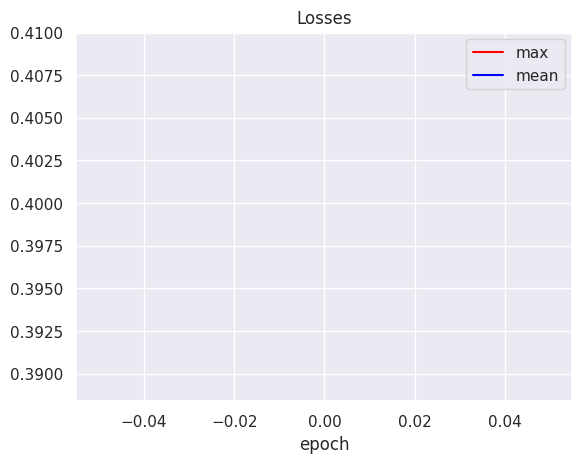

Лучшая accuracy для подхода max: 88.62
Лучшая accuracy для подхода mean: 87.20


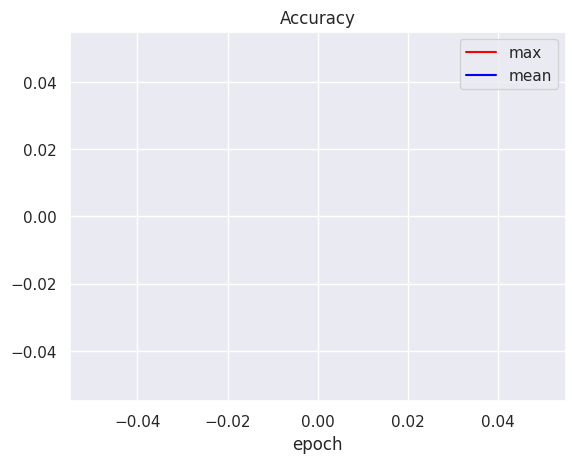

In [56]:
losses_plotter = LossesPlotter()
accuracy_plotter = AccuracyPlotter()

# Подготовка данных для графиков
losses_type = {'max': results['max']['losses'], 'mean': results['mean']['losses']}
acc_type = {'max': results['max']['accuracy'], 'mean': results['mean']['accuracy']}

# Построение графиков
losses_plotter.plot(losses_type, ['red', 'blue'])
accuracy_plotter.plot(acc_type, ['red', 'blue'])




### Проведение экспериментов по улучшению модели
* Эксперимент 1: увеличение dropout до 0.5



In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CharLM(hidden_dim=256, vocab_size=len(vocab), dropout_value=0.5).to(device)
num_epochs = 5
eval_steps = len(train_dataloader) // 2

# Запуск сессий обучения
results = run_training_sessions(model, train_dataloader, eval_dataloader, device, num_epochs, eval_steps)

In [ ]:
losses_plotter = LossesPlotter()
accuracy_plotter = AccuracyPlotter()

# Подготовка данных для графиков
losses_type = {'max': results['max']['losses'], 'mean': results['mean']['losses']}
acc_type = {'max': results['max']['accuracy'], 'mean': results['mean']['accuracy']}

# Построение графиков
losses_plotter.plot(losses_type, ['red', 'blue'])
accuracy_plotter.plot(acc_type, ['red', 'blue'])

Эксперимент 2: изменение архитектуры, dropout: 0.5

In [57]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, dropout_value: float,
        num_classes: int = 4,
        aggregator: Aggregator = MaxAggregator()
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_value)

        self.aggregator = aggregator

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        output = self.aggregator(output)

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction